In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

<h3>Load and Process Data</h3>

Load the processed data from the two pickled objects as two lists, dogs and cats

In [2]:
with open('dogs.obj','rb') as f:
    dogs = pickle.load(f)
    
with open('cats.obj','rb') as f:
    cats = pickle.load(f)

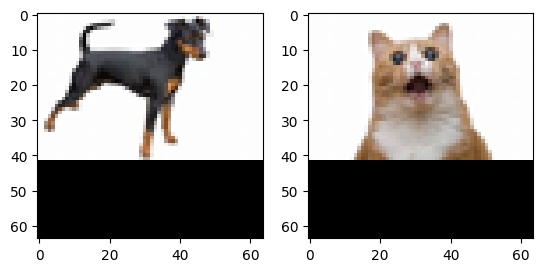

In [3]:
plt.subplot(121)
plt.imshow(dogs[10])
plt.subplot(122)
plt.imshow(cats[20])
plt.show()

Quick processing on the data. Images from dogs are labeled 'dog', and cats 'cat'. We also normalize the pixel values by dividing them by 255

In [4]:
X = np.array(dogs + cats)
Y = np.array(['dog']*len(dogs) + ['cat']*len(cats))

In [5]:
X_prc = X.reshape(-1,X.shape[1]*X.shape[2]*X.shape[3])
X_prc = X_prc/255

Train test split like other problems

In [14]:
from sklearn.model_selection import train_test_split

tvX, testX, tvY, testY = train_test_split(X_prc,Y,test_size=200)
trainX, validX, trainY, validY = train_test_split(tvX,tvY,test_size=200)

<h3> Modeling with SKLearn</h3>

SKLearn models can be used after the previous processing steps. They are not nearly as efficient and accurate as specialized models, but are a possibility

<h4> Logistic Regression </h4>

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

#hyperparameter grid for logistic regression, we only optimize regularization term C
param_grid = [{'C': [0.01,  0.1, 1 ,10, 100]}]

#create new model
logistic = LogisticRegression(max_iter=5000)

#perform grid search with 5-fold cross validation
grid_search = GridSearchCV(logistic, param_grid, cv=3, scoring='accuracy', return_train_score=True)

grid_search.fit(tvX,tvY)


KeyboardInterrupt



Let's look at the best model

In [9]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 0.01}
0.62


And apply it on the testing data

In [10]:
best_l2_logistic = grid_search.best_estimator_

best_l2_logistic.score(testX, testY)

0.645

<h4> Support Vector Machine </h4>

In [11]:
from sklearn.svm import SVC

svc = SVC()

param_grid = [{
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel' : ['rbf'],
    'gamma' : [0.01, 0.1, 1, 10, 100]
}]

grid_search = GridSearchCV(svc, param_grid, cv=3, scoring='accuracy', return_train_score=True)

grid_search.fit(tvX,tvY)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'gamma': [0.01, 0.1, 1, 10, 100],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='accuracy')

Let's check the best model

In [12]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.5888888888888889


And test it on testing data

In [13]:
best_svc = grid_search.best_estimator_
best_svc.score(testX, testY)

0.51

<h4>Neural Network</h4>

This model will take a very long time to run. We can skip it in sklearn and implement the same model in Tensorflow to utilize the GPU capability on Azure

In [17]:
from sklearn.neural_network import MLPClassifier

n_features = tvX.shape[1]

param_grid = [{
    'hidden_layer_sizes' : [
                            [n_features//2,n_features//2],                 #two hidden layer with n_features/2 neurons
                            [n_features//2,n_features//2,n_features//2]],   #three hidden layer with n_features/2 neurons
    'alpha' : [0.01, 0.1, 1]                                    #regularization terms
}]

mlp = MLPClassifier(max_iter=1000)

grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='accuracy', return_train_score=True)

grid_search.fit(tvX,tvY)

GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=1000),
             param_grid=[{'alpha': [0.01, 0.1, 1],
                          'hidden_layer_sizes': [[6144, 6144],
                                                 [6144, 6144, 6144]]}],
             return_train_score=True, scoring='accuracy')

Best training model:

In [18]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'alpha': 1, 'hidden_layer_sizes': [6144, 6144]}
0.5983333333333333


In [20]:
best_dt = grid_search.best_estimator_
best_dt.score(testX, testY)

0.63

<h3>Convolutional Neural Network</h3>

CNN (2D) is the specialized neural network type for image data. We will use tensorflow. We also need to convert the labels to 0 and 1 since we are no longer in sklearn. We also need to reshape the inputs back to image format (width\*heigh\*channel)

In [18]:
trainX = trainX.reshape(-1,64,64,3)
validX = validX.reshape(-1,64,64,3)
testX = testX.reshape(-1,64,64,3)
trainY = (trainY=='dog')*1
validY = (validY=='dog')*1
testY = (testY=='dog')*1

In [19]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD

In [26]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 3136)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)             

In [30]:
opt = SGD(lr=1e-5, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=100, 
                    validation_data=(validX, validY))

Epoch 1/100
50/50 [==============================] - 1s 15ms/step - loss: 0.4623 - accuracy: 0.8094 - val_loss: 0.6103 - val_accuracy: 0.6750
Epoch 2/100
50/50 [==============================] - 1s 10ms/step - loss: 0.4627 - accuracy: 0.8094 - val_loss: 0.6103 - val_accuracy: 0.6700
Epoch 3/100
50/50 [==============================] - 0s 10ms/step - loss: 0.4619 - accuracy: 0.8125 - val_loss: 0.6103 - val_accuracy: 0.6750
Epoch 4/100
50/50 [==============================] - 0s 10ms/step - loss: 0.4618 - accuracy: 0.8125 - val_loss: 0.6101 - val_accuracy: 0.6700
Epoch 5/100
50/50 [==============================] - 1s 10ms/step - loss: 0.4621 - accuracy: 0.8131 - val_loss: 0.6108 - val_accuracy: 0.6650
Epoch 6/100
50/50 [==============================] - 1s 10ms/step - loss: 0.4621 - accuracy: 0.8138 - val_loss: 0.6103 - val_accuracy: 0.6700
Epoch 7/100
50/50 [==============================] - 0s 10ms/step - loss: 0.4621 - accuracy: 0.8125 - val_loss: 0.6104 - val_accuracy: 0.6700
Epoch 

KeyboardInterrupt: 

A very simple CNN is able to obtain higher accuracies than the previous models

In [31]:
test_loss, test_acc = model.evaluate(testX, testY)
test_acc

7/7 [==============================] - 0s 4ms/step - loss: 0.6500 - accuracy: 0.6450


0.6449999809265137

In [17]:
testX.shape

(200, 12288)